In [1]:
import IPython
import IPython.display

import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import LSTM, LeakyReLU ,Flatten , Dense

import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.6.0


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
tf.test.is_built_with_cuda()

3 Physical GPUs, 3 Logical GPUs


True

# Import Data

In [4]:
InputData = np.genfromtxt('Data/InputData.csv',delimiter=",")
t = np.genfromtxt('Data/time.csv',delimiter=",")
Data = np.genfromtxt('Data/OutputData.csv',delimiter=",")
print(f"OutData: %s, \nInputData: %s, \nTime: %s" %(np.shape(Data),np.shape(InputData),np.shape(t)))

OutData: (1000, 100), 
InputData: (100, 4), 
Time: (1000,)


# Split The Data

In [5]:
n = Data.shape[1]
train_df = Data[:, 0:int(n*0.7):]
val_df = Data[:,int(n*0.7):int(n*0.9):]
test_df = Data[:,int(n*0.9):]

num_features = Data.shape[1]


# Normalize Data

In [6]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

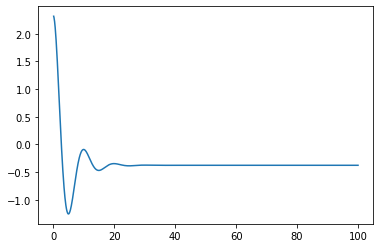

In [7]:
example_ind = 63
plt.plot(t,train_df[:,example_ind])


# Data Windowing

In [8]:
from window import WindowGenerator

Total window size: 39
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]

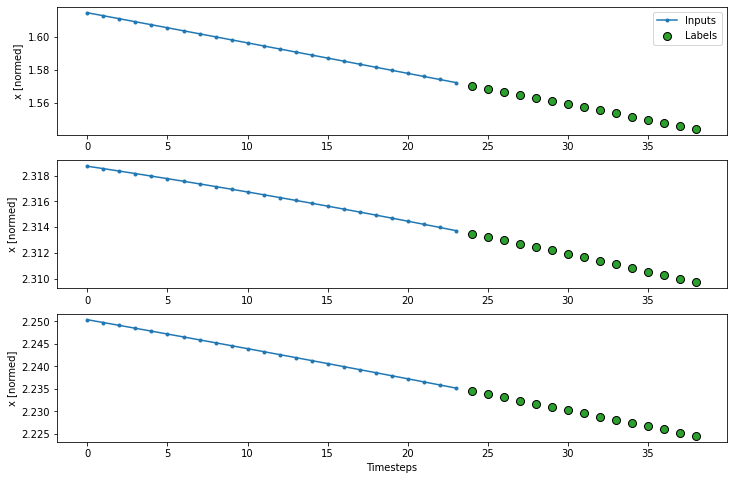

In [9]:
OUT_STEPS = 15
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               train_df=train_df,
                               val_df=val_df,
                               test_df=test_df)

multi_window.plotexample()
multi_window

# FeedBack Model

In [10]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units

        self.l1 = LSTM(units, activation='tanh', return_sequences=True,return_state=True,name = "LSTM1")
        self.l2 = LeakyReLU(alpha=0.4,name = "LR1")
        self.l3 = LSTM(units, activation='tanh', return_sequences=True,return_state=True,name = "LSTM2")
        self.l4 = LeakyReLU(alpha=0.4,name = "LR2")
        self.l5 = Flatten(name = "Flat")
        self.l6 = Dense(units,activation=None, use_bias=True,name="Dense1")
        self.l7 = LeakyReLU(alpha=0.4,name = "LR3")
        self.l8 = Dense(units=1,name="Output")

    def warmup(self, inputs):
        inp = inputs                                 #Input        => inputs.shape      => (batch, time, features)
        x, *carry_state1 = self.l1(inp)              #LSTM 1       => x.shape           => (batch, timesteps,lstm_units)
        x = self.l2(x)                               #LEAKY RELU 1 => x.shape           => (batch, timesteps,lstm_units)
        x, *carry_state2  = self.l3(x)               #LSTM_2       => x.shape           => (batch, timesteps,lstm_units)
        x = self.l4(x)                               #Leaky_ReLU_2 => x.shape           => (batch, timesteps,lstm_units)
        x = self.l5(x)                               #Flatten      => x.shape           => (batch, timesteps * lstm_units)
        x = self.l6(x)                               #Dense_1      => x.shape           => (batch, lstm_units)
        x = self.l7(x)                               #Leaky_ReLU_3 => x.shape           => (batch, lstm_units)
        prediction = self.l8(x)                      #Dense_2      => predictions.shape => (batch, 1)
        
        return prediction , carry_state1 ,carry_state2

In [11]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = inputs
  # Initialize the LSTM state.
  prediction, carry_state1, carry_state2 = self.warmup(inputs)
  # Insert the first prediction.
  predictions = tf.concat(axis=1, values = [predictions,tf.expand_dims(prediction,axis=2)]) # <<<< note the cast
  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    inp = predictions[:,n:,:]
    # Execute one lstm step.
    x, *carry_state1 = self.l1(inp , initial_state= [*carry_state1],
                                            training=training) #LSTM
    x = self.l2(x) #LEAKY RELU
    x, *carry_state2 = self.l3(x, initial_state= [*carry_state2], 
                                            training=training) #LSTM
    x = self.l4(x) #LEAKY RELU
    x = self.l5(x) #FLATEN
    x = self.l6(x) #DENSE/
    x = self.l7(x) #LEAKY RELU
    prediction = self.l8(x) #DENSELOL

    predictions = tf.concat(axis=1, values = [predictions,tf.expand_dims(prediction,axis=2)]) # <<<< note the cast

  # predictions.shape => (time, batch, features)
  return predictions[:,-OUT_STEPS:,:]

FeedBack.call = call

In [12]:
model =  FeedBack(units=256, out_steps=OUT_STEPS)
model(multi_window.example[0]).shape

TensorShape([700, 15, 1])

In [13]:
model.load_weights("Models/feedbackWeights.h5")

W: 0.34
Z: 0.11888888888888888
X0: 1.0
V0: 0.0


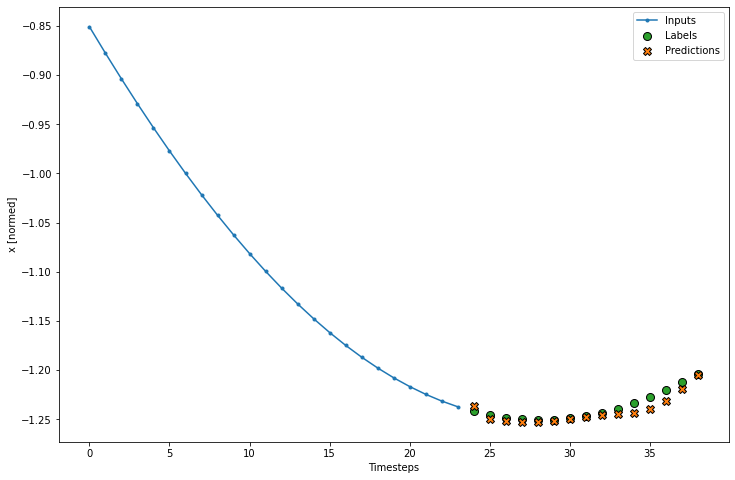

In [14]:
startTime = 250
exampleCase = 31
CaseParameters = InputData[exampleCase]
print("W: {}\nZ: {}\nX0: {}\nV0: {}".format(*CaseParameters))
multi_window.plot( inputs=train_df[startTime:startTime+multi_window.total_window_size, exampleCase], model=model)

In [63]:
def CalcCase(data, window, model):
    inputsRT = data[:window.input_width]
    outputsRT = data[:window.input_width]
    
    iw = window.input_width
    shift = window.shift
    i=0
    while(iw+shift*i<t.shape[0]):
        predRT = np.squeeze(model(np.reshape(inputsRT, (1, inputsRT.shape[0], 1))))
        outputsRT = np.hstack([outputsRT, predRT])
        inputsRT = outputsRT[-iw:]
        i+=1
    print("We had to execute {} calls\nPredicted {} timesteps".format(i,np.shape(outputsRT[iw:])[0]))
    return  outputsRT

In [64]:
testCase = train_df[:,10]
out = CalcCase(testCase,multi_window,model)

We had to execute 66 calls
Predicted 990 timesteps


In [71]:
predData = []
for i in range(train_df.shape[1]):
    print("\nTest Case:{}".format(i))
    testCase = train_df[:,i]
    ts  = CalcCase(testCase,multi_window,model)
    predData.append(ts)
predData =np.array(predData)


Test Case:0
We had to execute 66 calls
Predicted 990 timesteps

Test Case:1
We had to execute 66 calls
Predicted 990 timesteps

Test Case:2
We had to execute 66 calls
Predicted 990 timesteps

Test Case:3
We had to execute 66 calls
Predicted 990 timesteps

Test Case:4
We had to execute 66 calls
Predicted 990 timesteps

Test Case:5
We had to execute 66 calls
Predicted 990 timesteps

Test Case:6
We had to execute 66 calls
Predicted 990 timesteps

Test Case:7
We had to execute 66 calls
Predicted 990 timesteps

Test Case:8
We had to execute 66 calls
Predicted 990 timesteps

Test Case:9
We had to execute 66 calls
Predicted 990 timesteps

Test Case:10
We had to execute 66 calls
Predicted 990 timesteps

Test Case:11
We had to execute 66 calls
Predicted 990 timesteps

Test Case:12
We had to execute 66 calls
Predicted 990 timesteps

Test Case:13
We had to execute 66 calls
Predicted 990 timesteps

Test Case:14
We had to execute 66 calls
Predicted 990 timesteps

Test Case:15
We had to execute 66 

# Plot Data Individually

In [ ]:
def plotCase( outputsRT, window, data, index):
    fig = plt.figure()
    axes = fig.add_axes([0, 0, 1, 1])
    iw = window.input_width

    axes.plot(t[:iw], data[:iw], label="Input", linewidth=1.5)
    axes.plot(t[iw:], data[iw:], label="Target", linestyle="dotted",linewidth=1.5)
    axes.plot(t[iw:], outputsRT[iw:t.shape[0]], label='Predictions',
                c='#ff7f0e',linewidth = 1)

    axes.grid()
    axes.legend()
    axes.set_title("Test Case")
    extent=axes.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig("Graphs/Case" + str(index) + 'FeedBack.png',
                bbox_inches = extent.expanded(1.2, 1.3),
                dpi = 1000)
    plt.show()

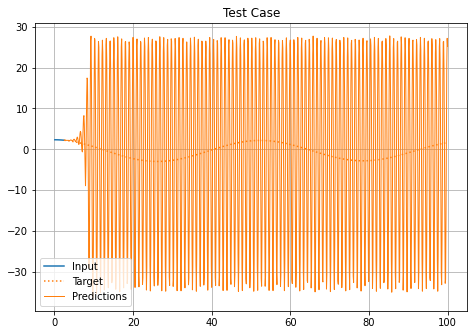

In [68]:
for ts1,ts2 in predData:
     plotCase(ts1,multi_window,testCase,i)

# Create Animation

In [72]:
from pltfigure import pltfigure

In [75]:
np.shape(train_df.T)

(70, 1000)

In [78]:
predData = np.array(predData)

In [ ]:
t.shape

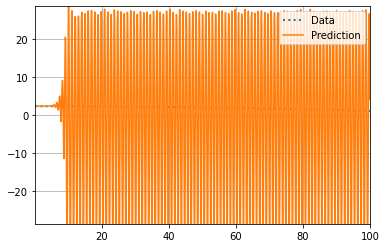

MovieWriter PillowWriter unavailable; using Pillow instead.


In [79]:
pltfigure(train_df.T,predData[:,:t.shape[0]],t,"Data","Prediction",'Graphs/datasetPred.gif')